### <center> Финальный проект: идентификация пользователя по посещенным веб-сайтам

# <center> Отчет

В данном проекте мы решали задачу идентификации пользователя по его поведению в сети. Данные для проекта были взяты из [статьи](http://ceur-ws.org/Vol-1703/paper12.pdf): "A Tool for Classification for Sequential Data". Эти данные собраны на прокси-серверах Университета Блеза Паскаля и имеют следующий вид. Для каждого пользователя создан файл user\*\*\*\*.csv (где вместо звездочек 4-значный id пользователя), в котором два столбца: **timestamp** с датой и временем захода на сайт и **site** c именем сайта.  

В данном проекте использовались выборки 10 users и 150 users, а также тестовый датасет для отладки 3 users.

Финальной целью проекта было участие в InClass [соревновании](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) на kaggle, которое специально создано под данный проект. В нем нужно отделить пользователя Alice от всех остальных.

## 1. Подготовка данных

Для каждого датасета был создан словарь по всем пользователям в него входящим вида:  
  
<center>{'имя сайта': (id сайта, частота появления сайта в датасете)}

In [8]:
site_freq = load_dict(os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'))
site_freq
# id даны сайтам по убываюнию популярности

{'google.com': (1, 9),
 'oracle.com': (2, 8),
 'vk.com': (3, 3),
 'meduza.io': (4, 3),
 'mail.google.com': (5, 2),
 'football.kulichki.ru': (6, 2),
 'geo.mozilla.org': (7, 1),
 'accounts.google.com': (8, 1),
 'apis.google.com': (9, 1),
 'plus.google.com': (10, 1),
 'yandex.ru': (11, 1)}

Далее была создана функция, разбивающая исходную историю на сессии длиной **session_length** с шагом **window_size** (сессии могут пересекаться) и с ограничением сессии по времени **time_limit** 

In [ ]:
def prepare_train_set(path_to_csv_files, path_to_dict, session_length=10, window_size=10, time_limit=5*60)

На выходе получается следующий датафрейм:

In [9]:
# сессии из id сайтов
train_data_3users.iloc[:, :15].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,site11,site12,site13,site14,site15
session_id,,,,,,,,,,,,,,,
1,3,2,2,0,0,0,0,0,0,0,0,0,0,0,0
2,7,2,1,8,5,9,10,0,0,0,0,0,0,0,0
3,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0
4,3,2,6,0,0,0,0,0,0,0,0,0,0,0,0
5,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# время проведенное на сайте для каждого сайта
train_data_3users.iloc[:, 15:30].head()

,diff_time1,diff_time2,diff_time3,diff_time4,diff_time5,diff_time6,diff_time7,diff_time8,diff_time9,diff_time10,diff_time11,diff_time12,diff_time13,diff_time14,diff_time15
session_id,,,,,,,,,,,,,,,
1,287,1184,6278,0,0,0,0,0,0,0,0,0,0,0,0
2,186,2,1,2,3,55,3540,0,0,0,0,0,0,0,0
3,2,3,55,0,0,0,0,0,0,0,0,0,0,0,0
4,287,1184,6278,0,0,0,0,0,0,0,0,0,0,0,0
5,186,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Так как для создания признаков связанных со временем нужен исходный timestamp, то в этой же функции было реализовано создание таких признаков (их описание будет дано позже).

In [15]:
train_data_3users.iloc[:, 30:37].head()

,start_hour,day_of_week,year,month,day,time_of_day,user_id
session_id,,,,,,,
1,9,4,2013,11,15,0,1
2,11,4,2013,11,15,0,1
3,12,4,2013,11,15,1,1
4,9,4,2013,11,15,0,2
5,11,4,2013,11,15,0,2


Полученные сессии из сайтов были преобразованы в "мешок слов", то есть строками остались сессии, а столбцом стал каждый уникальный сайт. При этом значениями таблицы стали частоты появления сайта в сессии. Если провести аналогию с текстами, то сессии это отдельные документы, а сайты это слова.

## 2. Подбор модели

На "мешке слов" без признаков были испробованы различные модели, их результаты показаны в таблице ниже.

In [25]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695
logit,0.808,0.830,0.778,0.981,0.806,0.761
logit_wb,0.786,0.808,0.772,0.980,0.767,0.791
svm,0.813,0.831,0.781,NaN,0.813,0.761
svm_wb,0.801,0.820,0.779,NaN,0.784,0.782
sgd_logit,0.808,0.811,0.762,0.976,0.789,0.744
sgd_logit_tfidf,0.832,0.833,0.783,0.975,0.852,0.749
pipe_sgd_logit,0.898,0.906,0.884,0.990,0.894,0.877


Видно, что для данной задачи хорошо подходит логистическая регрессия и метод опорных векторов. Причем SVM показал лучший результат на кросс-валидации, и не очень большой прирост на отложенной выборке. Так как в задаче на kaggle требуется предсказывать вероятности, то дальше я работал с логистической регрессией.  
  
Встроенная балансировка классов увеличивает полноту, но при этом ухудшает точность, в дальнейшем стоит попробовать сделать oversampling вручную.  
  
Вместо самостоятельного создания "мешка слов" я применил TfidfVectorizer, что дало заметный прирост точности.  
  
Последней строчке в таблице соответствует мой итоговый pipeline, в котором к мешку слов добавлены признаки.

Дополнительно были подготовлены датасеты с различными параметрами, лучшими оказались:  
    session_length = 15  
    window_size = 5  
    time_limit = 30  
  
Правда в соревновании kaggle эти параметры строго заданны и дальше это не пригодилось. В соревновании датасет подготовлен с параметрами:  
    session_length = 10  
    window_size = 10  
    time_limit = 30  

In [18]:
score_table.groupby('session_length').mean()[['cv_score', 'hold_out_score']]

,cv_score,hold_out_score
session_length,,
5,0.711400,0.7258
7,0.743300,0.7578
10,0.772133,0.7866
15,0.818000,0.8372


In [19]:
score_table.groupby('window_size').mean()[['cv_score', 'hold_out_score']]

,cv_score,hold_out_score
window_size,,
5,0.78075,0.795100
7,0.77440,0.792467
10,0.76110,0.777500


In [20]:
score_table.groupby('time_limit').mean()[['cv_score', 'hold_out_score']]

,cv_score,hold_out_score
time_limit,,
5,0.756778,0.773000
10,0.773111,0.783778
15,0.776667,0.794333
20,0.780667,0.798444
30,0.784111,0.802000


## 3. Начальный pipeline соревнования Catch Me

Разделим признаки по категориям, чтобы работать отдельно с каждой внутри пайплайна.  
  
$\color{green}{site\_i}$ - i-й сайт в сессии, к ним будем применен TfidfVectorizer;  
$\color{green}{is\_top\_i}$ - наличие сайта топ-i в сессии, взяты 30 сайтов, тк их много, выберем из них лучшие с помощью TruncatedSVD;  
$\color{green}{start\_hour}$ - час начала сессии;  
$\color{green}{day\_of\_week}$ - день недели начала сессии;  
$\color{green}{day}$ - календарный день начала сессии;  
$\color{green}{time\_of\_day}$ - время дня начала сессии (утро - 0, день - 1, вечер - 2);  
$\color{green}{session\_timespan}$ - длина сессии, сек;  
$\color{green}{unique\_sites}$ - кол-во уникальных сайтов в сессии;  
$\color{green}{top\_sites\_time}$ - среднее время за сессию проведенное на сайтах из топ-30  
  

In [ ]:
bag_of_sites = ['site'+str(i) for i in range(1, 11)]
is_top_feats = ['is_top'+str(i) for i in range(1, 31)]
categorical_feats = ['start_hour', 'day_of_week', 'day', 'time_of_day']
binary_feats = ['sess_timespan_flag', 'top_sites_time_flag']
numerical_feats = ['session_timespan', 'unique_sites', 'top_sites_time']

К категориальным признакам тоже применим TruncatedSVD, иначе модель переобучается.

In [18]:
log_preprocessor = ColumnTransformer([
    ('log_scaling', FunctionTransformer(lambda data: np.log(data+0.01)), 
     ['session_timespan', 'top_sites_time'])
],
remainder='passthrough')

In [18]:
pipeline = Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables', FunctionTransformer(lambda data: data.loc[:, binary_feats])),
        ('categorical_variables', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, categorical_feats])),
            ('hot_encoding', OneHotEncoder(handle_unknown='ignore')),
            ('dim_reducing', TruncatedSVD(10))
        ])),
        ('bag_of_sites', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, bag_of_sites].apply(lambda row: \
                                                                        ' '.join([str(x) for x in row]), axis=1))),
            ('vectorizer', TfidfVectorizer())
        ])),
        ('is_top_site', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, is_top_feats])),
            ('dim_reducing', TruncatedSVD(10))
        ])),
        ('numerical_variables', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, numerical_feats])),
            ('log_preprocessing', log_preprocessor),
            ('scaling', StandardScaler())
        ]))
    ])),
    ('classifier', SGDClassifier('log'))
])

Подберем количество компонент в TruncatedSVD

In [52]:
pipe_grid_searcher.best_params_

{'feature_processing__categorical_variables__dim_reducing__n_components': 50,
 'feature_processing__is_top_site__dim_reducing__n_components': 24}

In [53]:
get_scores_point(pipe_grid_searcher.best_estimator_, 'pipe_sgd_logit')

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
pipe_sgd_logit,0.994,0.994,0.579,0.986,0.786,0.459


Но на Kaggle score всего лишь 0.88879

Видимо при большом количестве признаков алгоритм переобучается и из-за этого плохой результат на Kaggle. Возьмем значения количеств компонент в точке, где наклонная переходит в горизонталь.

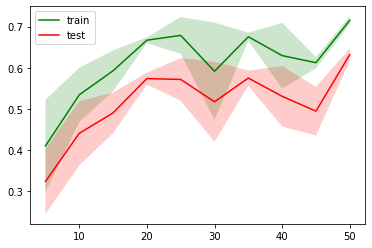

In [59]:
plot_validation_curves(param_grid['feature_processing__categorical_variables__dim_reducing__n_components'], 
                       pipe_grid_searcher.cv_results_)

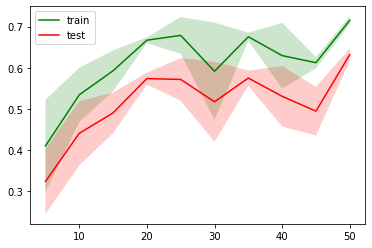

In [59]:
plot_validation_curves(param_grid['feature_processing__categorical_variables__dim_reducing__n_components'], 
                       pipe_grid_searcher.cv_results_)

In [21]:
pipeline.set_params(feature_processing__categorical_variables__dim_reducing__n_components=20)
pipeline.set_params(feature_processing__is_top_site__dim_reducing__n_components=7)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000245013075E0>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000024501307820>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore')),
                                                                 ('dim_reducing',
                                                                  Tru...
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000024501307CA0>)),
    

In [22]:
get_scores_point(pipeline, 'pipe_sgd_logit')

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
pipe_sgd_logit,0.992,0.993,0.456,0.984,0.769,0.324


При этом на Kaggle:

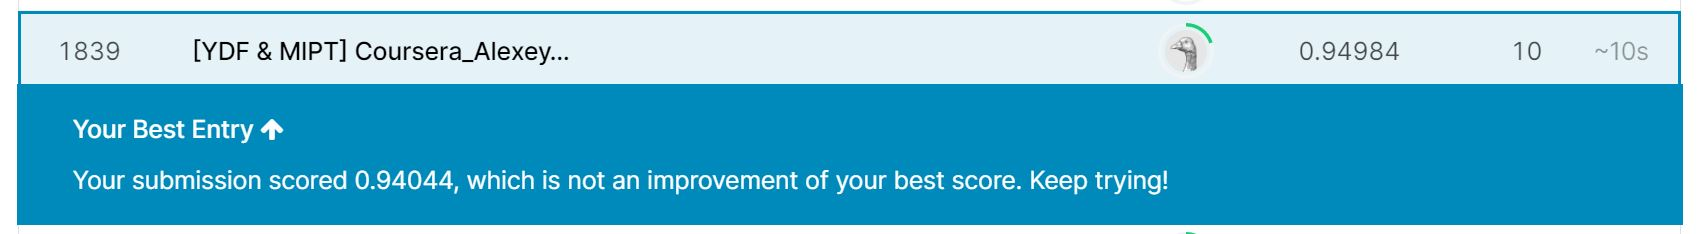

## 4. Анализ признаков

Для удобства признаки рассматривались на данных по 10 пользователям.

#### start hour

Уменьшим кол-во категорий, не потеряв основную информацию. Часы захода в сеть распределены с 7 утра до полуночи (24:00)

In [7]:
data_10users['binned_start_hour'] = pd.cut(data_10users.start_hour, bins=7)

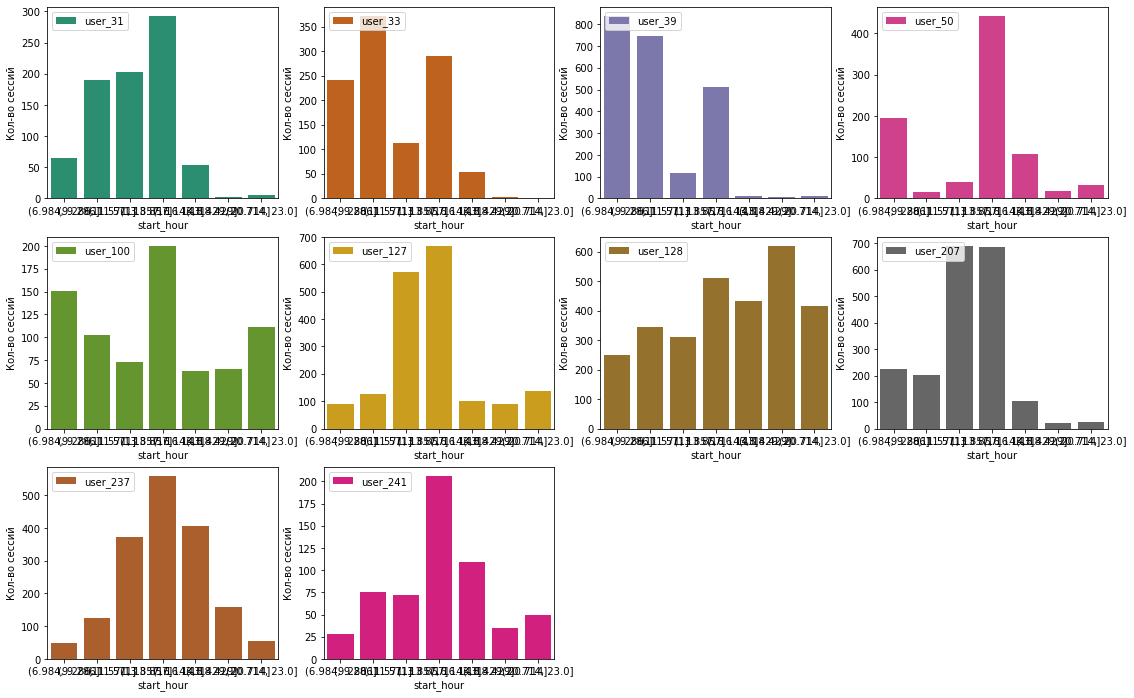

In [68]:
count_users(data_10users, 'binned_start_hour', 'start_hour')

Видим, что распределения немного отличаются, кто-то вечером не заходит в сеть, у каждого есть часы с максимальной активностью.

#### day of week

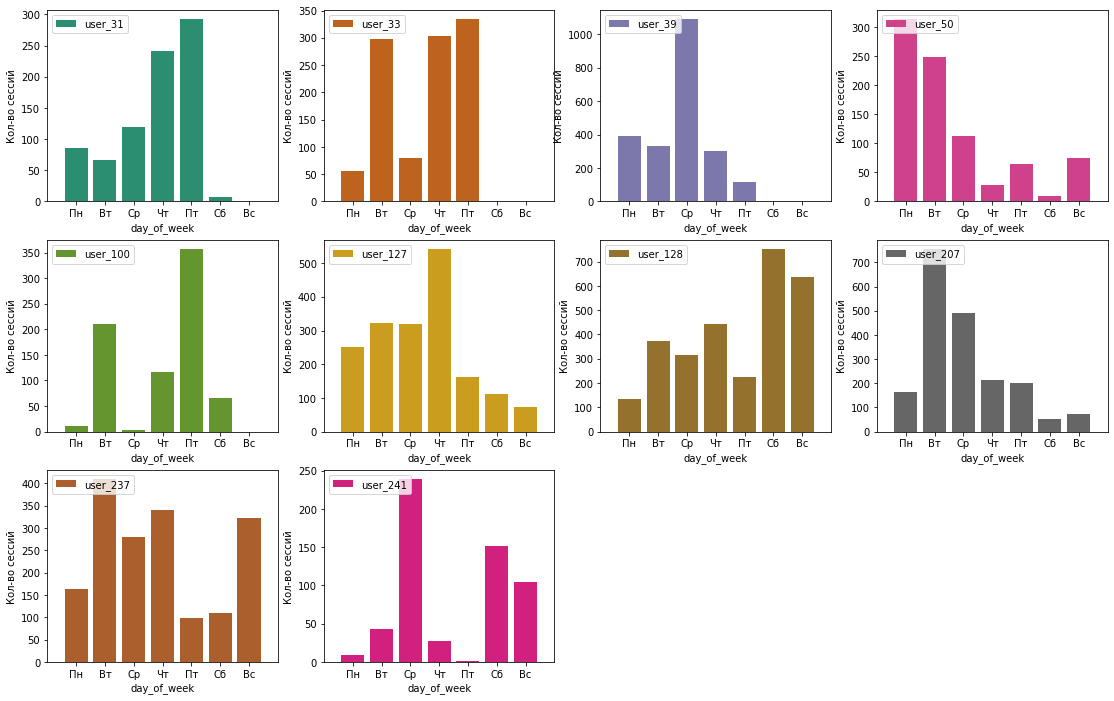

In [91]:
count_users(data_10users, 'day_of_week', 'day_of_week', xticks=xticks)

Можно увидеть, что каждый день недели значимый и стоит оставить этот признак как есть

#### session timespan

In [ ]:
plt.figure(figsize=(12, 7))
sns.histplot(x='session_timespan', hue='user_id', 
             data=data_10users[data_10users.session_timespan<100], 
             palette='Set2', element='step', stat='probability', common_norm=False)
plt.title('Продолжительность сессии', pad=10)
plt.show()

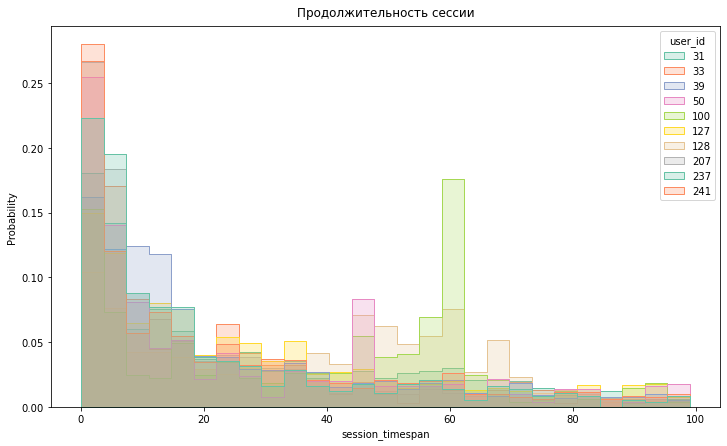

Сделаем Weight of Evidence encoding с тремя спосабами заполнения пропусков и посмотрим на гистограммы.  
Возьмем диапазон [0, 100] и разобьем его на 25 бинов. Для каждого бина и каждого пользователя посчитаем weight of evidence как логарифм отношения вероятностей принадлежности к классам {1, 0} в бинарной классификации. 

Значения больше 100 добавим к получившемуся признаку 3-мя способами: как 0, как -20 и как случайный шум.

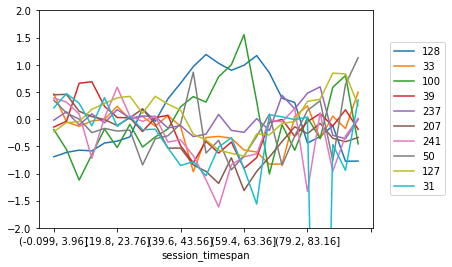

In [12]:
# посмотрим как каждый диапазон session_timespan влияет на вероятность отнесения объекта к i-му классу
for i, user_id in enumerate(set(data_10users.user_id)):
    woe_dicts_10users[i].plot(label=user_id)
plt.ylim(-2, 2)
plt.legend(loc=(1.05, 0.15))
plt.show()

Для каждого из классов есть отклонения от нуля, нельзя сказать, что по этому признаку можно отделить каждый класс, но как минимум сгруппировать можно.

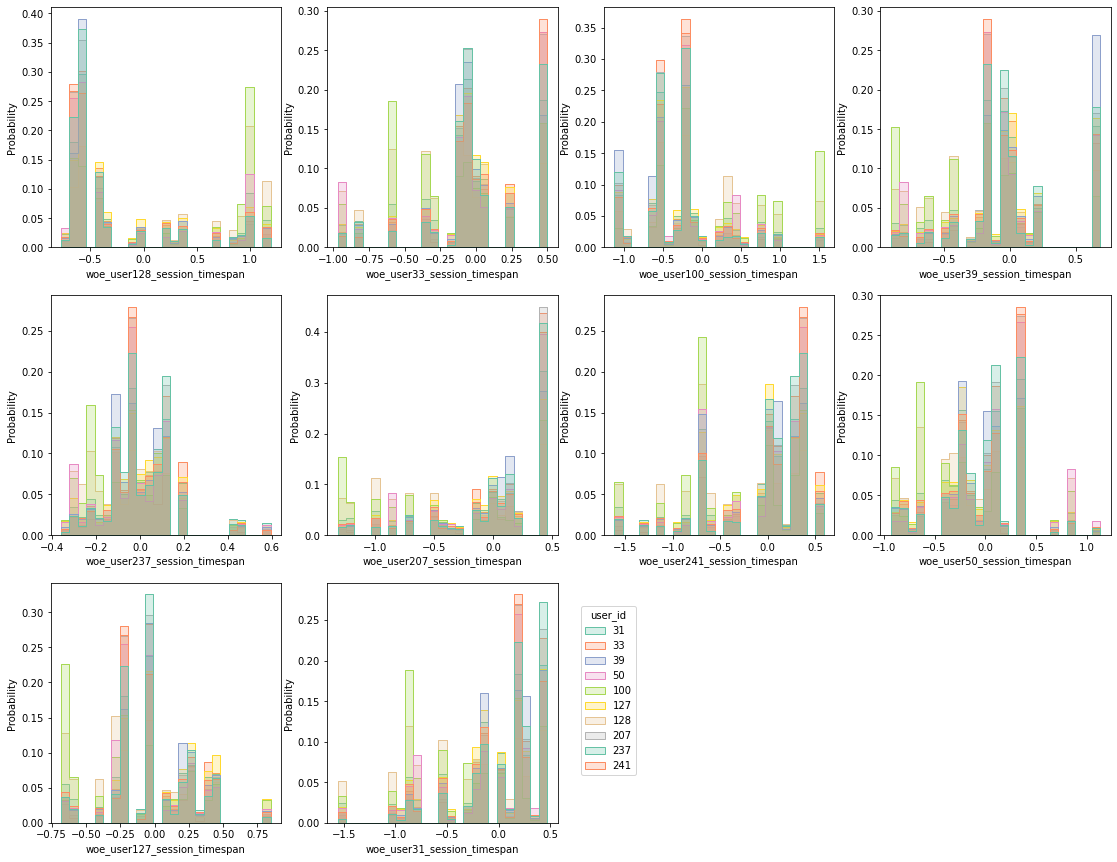

In [18]:
hist_woe(data_10users_3, 'session_timespan')

Как видно из графиков, классы сильно перемешаны, но некоторые из них можно выделить. Самый простой способ при обучении попоробовать все три способа заполнения пропусков, а сами признаки отобрать через понижение размерности. Когда мы будем брать 150 пользователей или 3000, то соответсвенно увеличится и количество классов и этих признаков, что будет приводить к переобучению, поэтому отбор признаков обязателен. В соревновании Catch Me будет всего один признак, его можно будет отдельно рассмотреть и решить, несет ли он какую либо информацию.

#### unique_sites

Посмотрим на кол-во уникальных сайтов в сессии

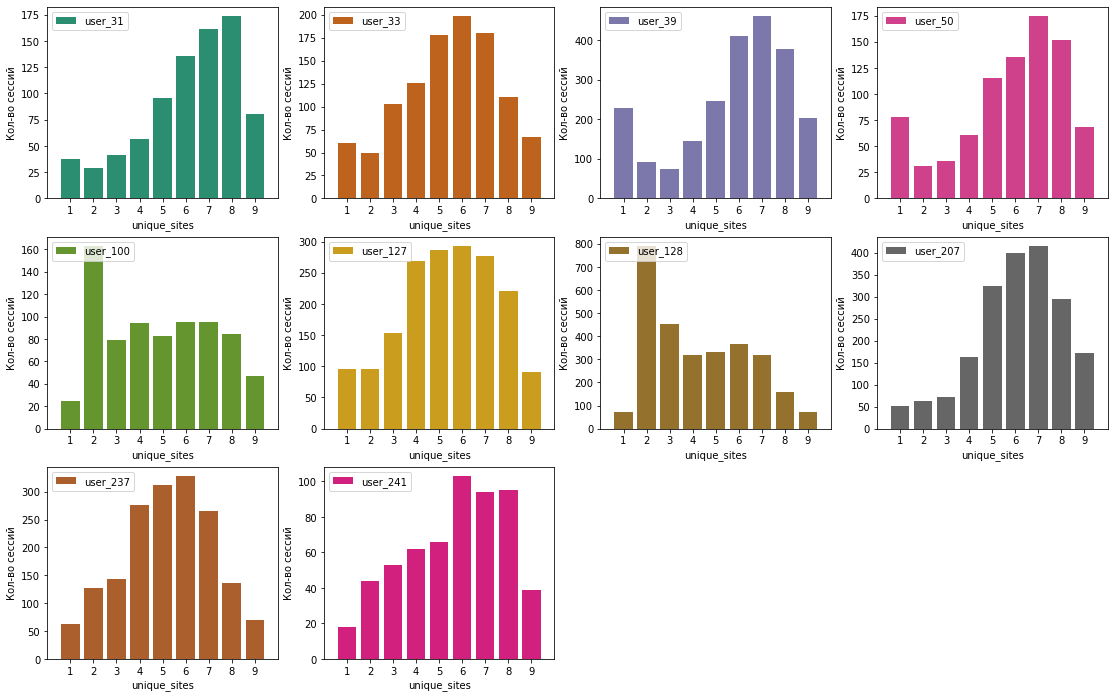

In [75]:
count_users(data_10users, 'unique_sites', 'unique_sites', xlims=(0, 8))

У некоторых пользователей есть выделяющийся пик в 1 и 2, сделаем дополнительные бинарные признаки, описывающие это свойство.

#### facebook frequency

Посмотрим на частоту захода на Facebook за сессию

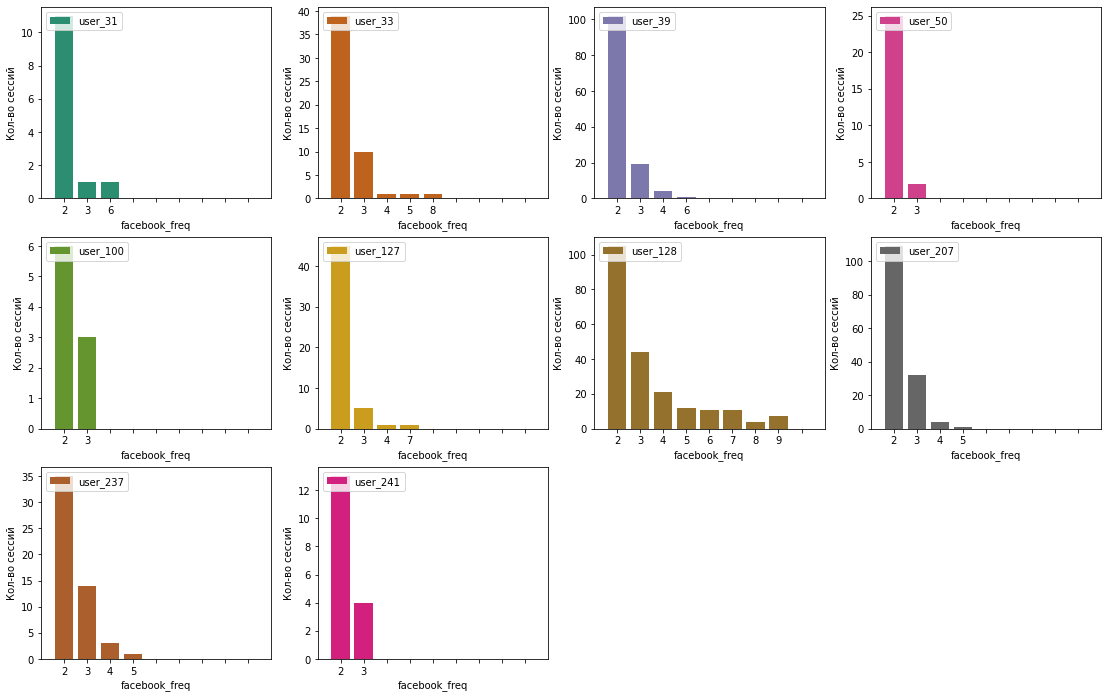

In [8]:
count_users(data_10users[data_10users['facebook_freq']>1], 'facebook_freq', 'facebook_freq', xlims=(0, 8))

Если убрать значения признака 0 и 1, то видны различия в хвостах распределений. Чтобы убрать 0 и 1, сделаем бинарный признак который принимает 1, когда **facebook_freq** принимает эти значения.

#### is_top_i

Бинарные признаки, показывающие наличие сайта из топ-30 в сессии

In [ ]:
_, axes = plt.subplots(nrows=6, ncols=5, figsize=(22, 25), sharex=True)
axes = axes.ravel()
for i in range(1, 31):
    sns.barplot(x='user_id', y='is_top'+str(i), data=data_10users, ax=axes[i-1])

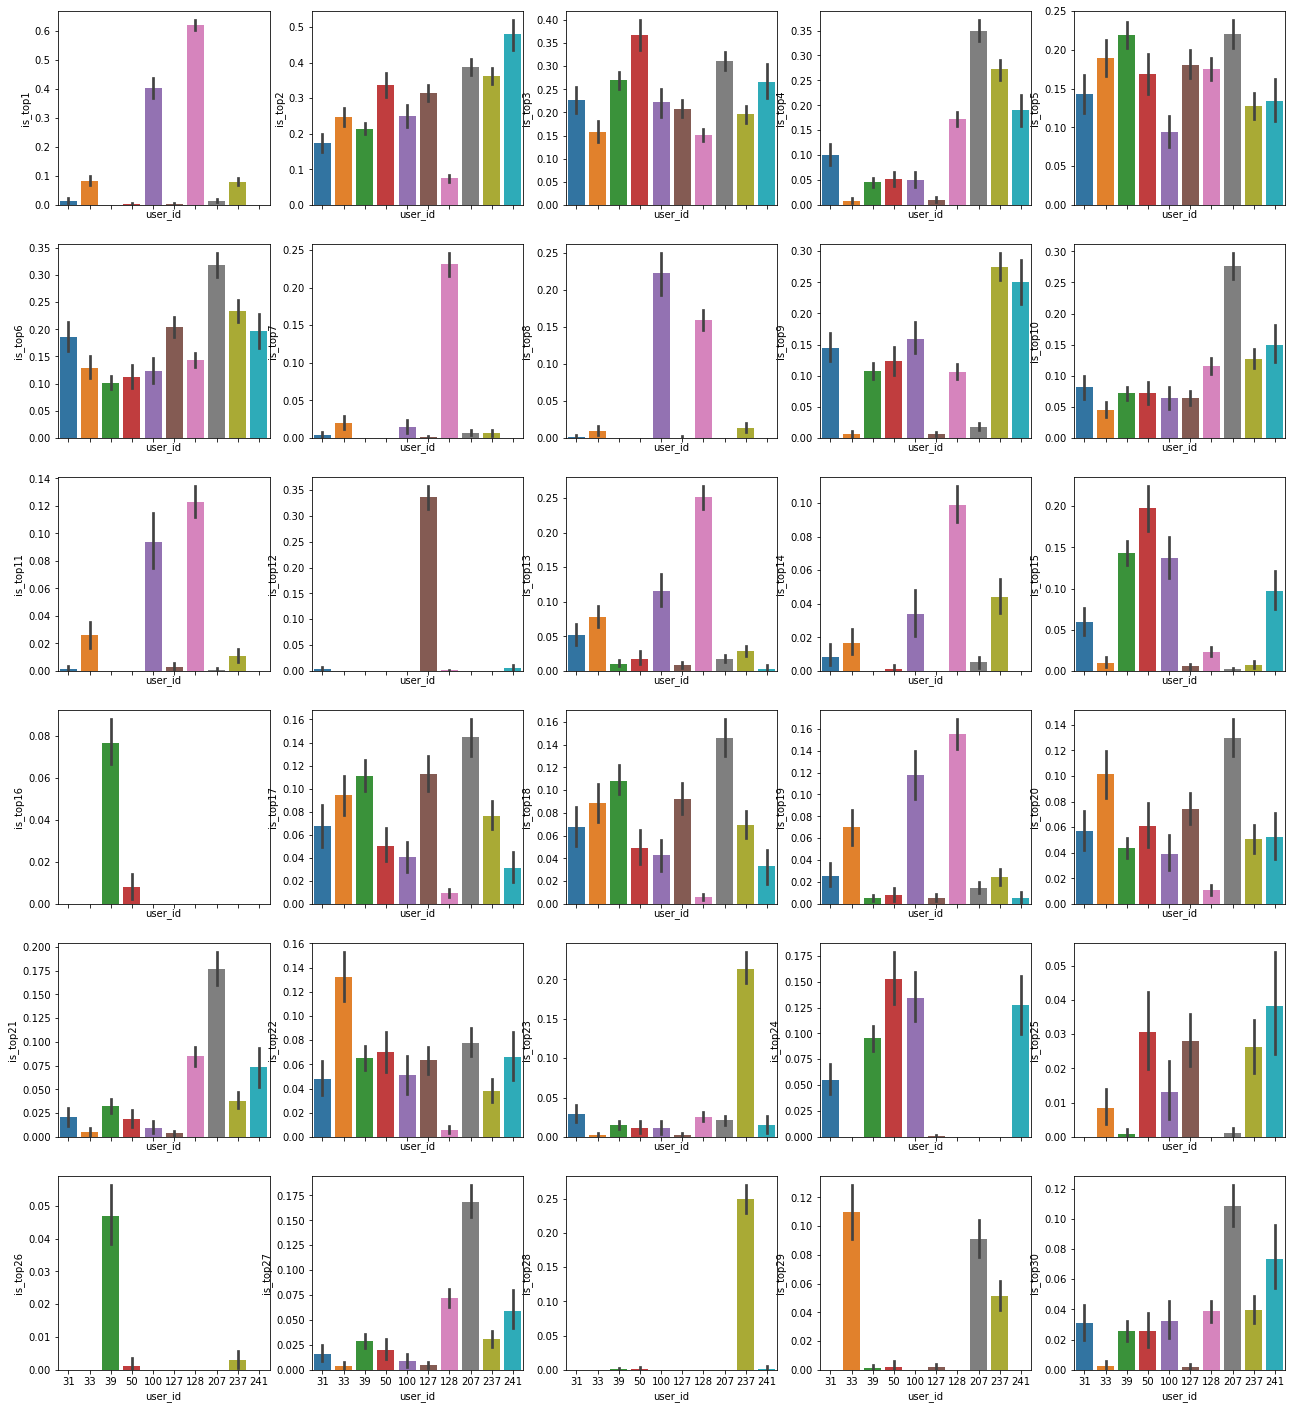

Видно, что многие признаки хорошо отделяют отдельные классы, поэтому их точно нужно использовать.

#### year, month

Данные представлены всего за 7 месяцев, с ноября 2013 по май 2014. Отсюда сложно выявить годовую сезонность. Поэтому использовать год и месяц в качестве признака не будем.

#### day of month

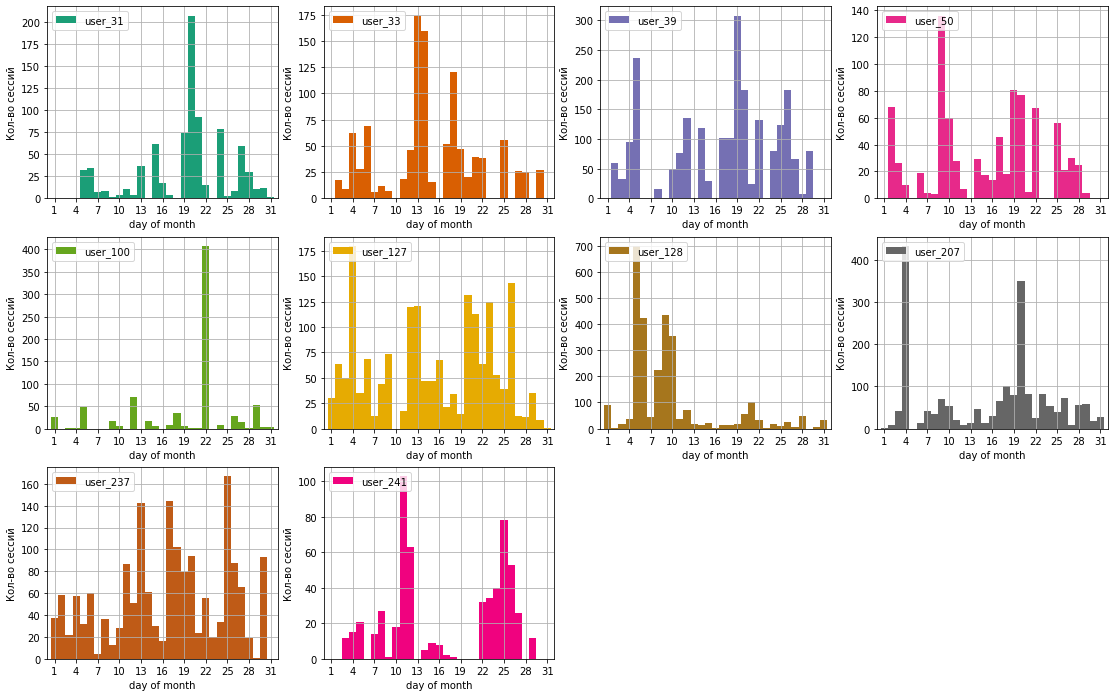

In [60]:
count_users(data_10users, 'day', 'day of month', ticks_delta=3)

Пользователи хорошо различаются по данному признаку.

## 5. Xgboost

Были использованы новые признаки без WoE-encoding'а и признака **session_timespan**. Испробованы 3 вида моделей, получены следующие результаты:

In [61]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
logit,0.839,0.839,0.81,0.982,0.834,0.796
svm,0.841,0.851,0.82,0.967,0.839,0.809
xgboost,0.879,0.894,0.88,0.992,0.887,0.874


Как и ожидалось бустинг дает лучший результат, применим его к соревнованию **Catch Me**

Тк в данных соревнования сайты уже без названий, то непонятно какой из них - **Facebook**. Поэтому признаки **facebook_freq** и **facebook_flag** использовать невозможно.

In [41]:
get_scores_point(pipeline, 'xgb_n20_d5_nowoe', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb_n20_d5_nowoe,0.994,0.994,0.762,0.985,0.933,0.688


Бустинг дал такие же **accurascy** и **roc-auc** как и линейные методы, но **f-мера** стала значительно больше.

Но при обучении на тесте и submit'е на Kaggle, score получился очень плохой (**0.738**), если увеличить коэффициенты регуляризации получается поднят score до **0.818**, что намного хуже baseline'а.

Очевидно, что модель переобучается и этого не показывает кросс-валидация. Здесь (https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme) автор соревнования говорит о том, что схема кросс-валидации должна строиться с учетом временной природы данных. Попробуем это сделать.

Если применить TimeSeriesSplit в схеме кросс-валидации, то на тесте получаются значения скора намного меньше, чем на обучении. Можно предположить, что эта схема лучше. (На графике f1-score)

In [8]:
time_split = TimeSeriesSplit(n_splits=5)

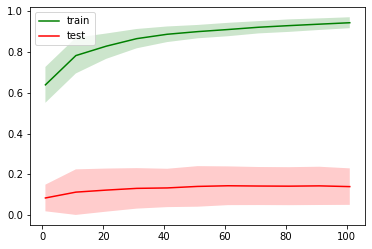

In [33]:
plot_validation_curves(xgb_params_cv['classifier__n_estimators'], xgb_searcher.cv_results_)

Если применить дефолтный xgb, получается следующее:

In [35]:
get_scores_point(pipeline, 'xgb', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb,0.991,0.991,0.498,0.599,0.495,0.5


Если внутри приведенного выше pipeline'a то получше:

In [47]:
get_scores_point(pipeline, 'pipe_xgb_n70', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
pipe_xgb_n70,0.965,0.991,0.564,0.947,0.733,0.538


На kaggle получается 0.90331, что по-прежнему хуже baseline'a, но всего на сотую.

Попробуем подобрать параметры:

In [ ]:
xgb_params = {'classifier__n_estimators': 30,
             'classifier__max_depth': 7,
             'classifier__learning_rate': 0.4}
pipeline.set_params(**xgb_params)

In [ ]:
xgb_params_cv = {'classifier__n_estimators': np.arange(10, 101, 10)}

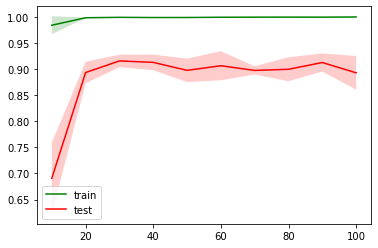

In [21]:
plot_validation_curves(xgb_params_cv['classifier__n_estimators'], xgb_searcher.cv_results_)

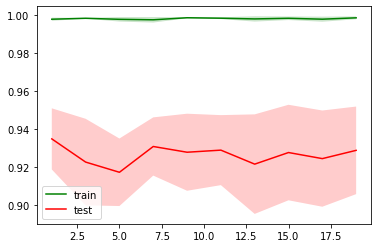

In [41]:
# with cat_features=10
plot_validation_curves(xgb_params_cv['feature_processing__is_top_site__dim_reducing__n_components'], 
                       xgb_searcher.cv_results_)

Признаки is_top_site не дают прироста score, поэтому их не будем использовать

In [73]:
pipeline.fit(X_train, y_train)
get_scores_point(pipeline, 'pipe_xgb_tuned', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
pipe_xgb_tuned,0.977,0.991,0.552,0.948,0.862,0.529


Получается хорошая **precision** и остальные метрики, но на Kaggle качество все равно хуже, чем у линейной модели.

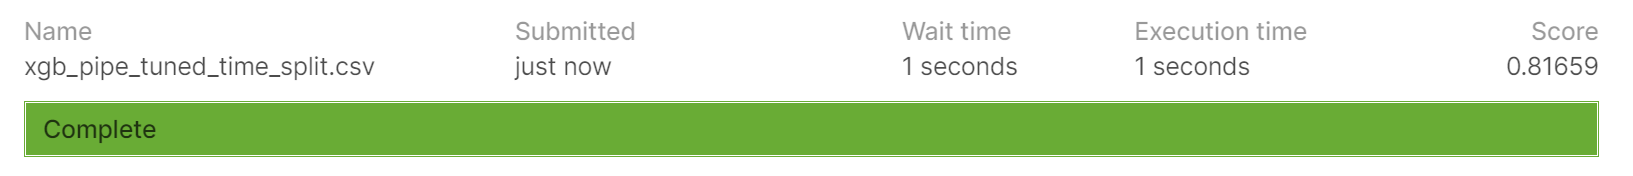

# Вывод:

Данная модель может применяться для идентификации мошенника, зашедшего под аккаунтом пользователя, если обучать ее не на истории браузера, а на истории поведения на каком-либо сайте. У нее не очень большая точность, а полнота еще меньше. В данной задаче полнота кажется важнее, тк получить предупреждение о нестандартной деятельности пользователя и ошибиться не так плохо как пропустить мошенника. Поэтому настраивать и устанавливать порог нужно в сторону полноты.  
  
Тк лучше всего себя показали линейные модели, то дальше можно попробовать нейросети из нескольких простых слоев. Также отборать признаки методом перебора и попробовать признак **woe_session_timespan**.